Plane regular waves - Airy (Linear) Theory
====================================================

Free-surface elevation equation:

$$
\eta(\vec{x},z,t)=0.5 H \cos (\vec{k}\cdot\vec{x}-\omega t +\phi) 
$$

Equation of velocity along the wave propagation direction:

$$
U_h(\vec{x},z,t)=0.5 H\omega \cos (\vec{k}\cdot\vec{x}-\omega t +\phi)\frac{\cosh(k(d+z))}{\sinh(kd)}
$$

Equation of velocity along the gravity direction:

$$
U_v(\vec{x},z,t)=0.5 H\omega \sin (\vec{k}\cdot\vec{x}-\omega t +\phi)\frac{\sinh(k(d+z))}{\sinh(kd)}
$$




`MonochromaticWaves` Class for Linear waves
======================================================

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import sys


Load WaveTools from proteus source files, without compiling


In [7]:
sys.path.append("C:/Users/present/Desktop/proteus/")
#The notebook will work with the following commit:
#https://github.com/erdc-cm/proteus/commit/9bb34b3563b5ddab6cb1dd9f75173da2710d2a41
from proteus import Profiling,SpatialTools
#import imp
#WT = imp.load_source('WaveTools', 'WaveTools.pyx')


Load WaveTools if proteus is installed


In [8]:
from proteus import WaveTools as WT

Setting up wave parameters and calling the class
=========================================

A brief description of the arguments is given in the source code. WaveTools does some basic checks and logs error messages if inconsistencies are found among the parameters

In [9]:
waveType ="Linear"
period = 2.
waveHeight = 0.025
mwl = 0.
depth = 1.
g = np.array([0., 0., -9.81])
waveDir = np.array([1., 2., 0.])
wavelength = None
Ycoeff = None
Bcoeff = None
meanVelocity = np.array([0., 0., 0.])
phi0 = 0.

#Calling the class
MW = WT.MonochromaticWaves(period,
                        waveHeight,
                        mwl,
                        depth,
                        g,
                        waveDir,
                        wavelength,
                        waveType,
                        Ycoeff,
                        Bcoeff,
                        meanVelocity,
                        phi0
                        )
                


We use class functions `eta` and `u` for calculating free-surface elevation (as a scalar) and velocity (as a vector).  


Calculating and plotting waves
=============================================================

Setting up the 3D domain

In [10]:
n=201
xi = np.linspace(0, 20, n)
yi = np.linspace(0, 20, n)
zi = np.linspace(mwl-depth, mwl+waveHeight, n)

We can calculate a time series of the free-surface elevation using the `eta` function and looping over time for a fixed point in space

In [11]:
nperiod = 4
npoints = 20
nn  = npoints * nperiod
tnlist=np.linspace(0,nperiod*period,nn)
eta_t = np.zeros(len(tnlist),)

psize = 20 
#Calculating time series
x = [2., 0.5, 0.]
for i in range(len(tnlist)):
    t = tnlist[i]
    eta_t[i] = MW.eta(x, t)

    
Plotting the timeseries

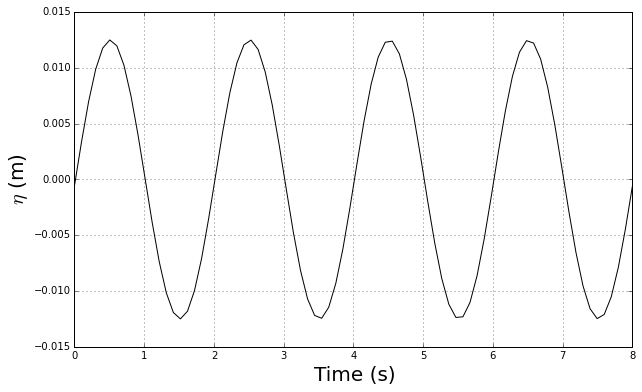

In [12]:
plt.figure(2,figsize=(10,6), dpi=100)
plt.xlim(0., nperiod*period)
plt.plot(tnlist, eta_t,"k-")
plt.xlabel("Time (s)", size=psize)
plt.ylabel("$\eta$ (m)", size=psize)
plt.grid()
plt.show()

We can also plot the free-surface at the x-y plane (wave propagation plane) using a contour plot

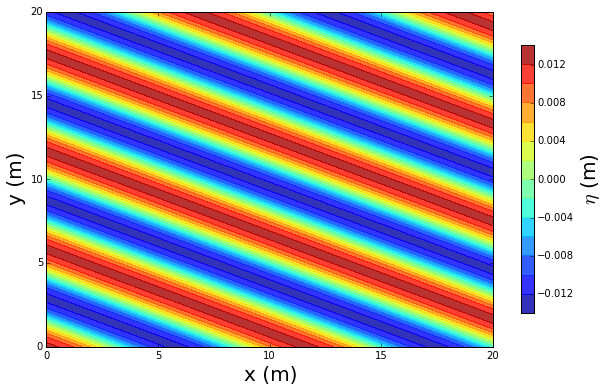

In [13]:
eta_xy = np.zeros((n, n),)
for i in range(len(xi)):
    for j in range(len(yi)):
        x = [xi[i], yi[j], 0]
        eta_xy[i,j] = MW.eta(x, 0.)
#Plotting the contour
plt.figure(1,figsize=(10, 6), dpi=100)
X,Y = np.meshgrid(xi,yi)
CS = plt.contourf(Y,X,eta_xy, 16, alpha=0.8, cmap='jet')
plt.xlabel("x (m)", size=psize)
plt.ylabel("y (m)", size=psize)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
CB.set_label("$\eta$ (m)", size = psize)
plt.xlim(0,max(xi))
plt.ylim(0,max(yi))         
plt.show()


In the next cell we plot contours, showing horizontal and vertical velocity profiles at a vertical plane, aligned with the wave propagation direction 


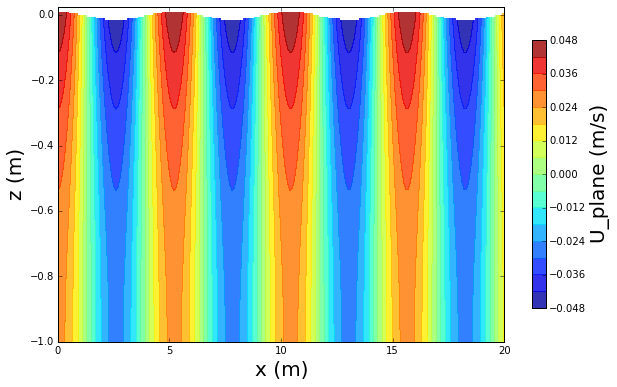

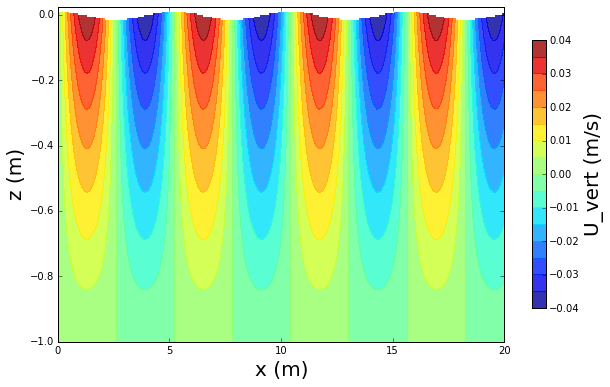

In [15]:
norm = WT.setDirVector(waveDir)
normVert = WT.setVertDir(g)
ur  = np.zeros((len(xi),len(zi)),)
uv  = np.zeros((len(xi),len(zi)),)
for i in range(len(xi)):
    for ii in range(len(zi)):
        x = xi[i]*norm + [0,0,zi[ii]]
        ur[i,ii] = sum(MW.u(x, 0.)[:]*norm[:])
        uv[i,ii] = sum(MW.u(x, 0.)[:]*normVert[:])  
        if zi[ii]>  MW.eta(x, 0.):
            ur[i,ii] = np.nan
            uv[i,ii] = np.nan
    
#Plotting velocity contours
plt.figure(3,figsize=(10, 6), dpi=100)
X,Y = np.meshgrid(zi,yi)
CS = plt.contourf(Y,X,ur, 16, alpha=0.8, cmap='jet')
plt.xlabel("x (m)", size=psize)
plt.ylabel("z (m)", size=psize)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
CB.set_label("U_plane (m/s)", size = psize)
plt.show()

plt.figure(4,figsize=(10, 6), dpi=100)
X,Y = np.meshgrid(zi,yi)
CS = plt.contourf(Y,X,uv, 16, alpha=0.8, cmap='jet')
plt.xlabel("x (m)", size=psize)
plt.ylabel("z (m)", size=psize)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
CB.set_label("U_vert (m/s)", size = psize)
plt.show()